In [1]:
import os
import glob
import collections

import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from CCfun  import compute_baseline
from CCfun  import power_to_quanta_rate

from CCplot import plot1d
from CCplot import plot2d
from CCplot import plot_line
from CCplot import temporary
from CCplot import auto_plot_style

In [2]:
%matplotlib inline

auto_plot_style()

In [3]:
Measurement = collections.namedtuple("Measurement", "crystals references background metadata")
Experiment  = collections.namedtuple("Experiment" , "pre post")

In [61]:
filename = "/Users/Gonzalo/github/CCdata/SF/fitting/data/SP_data_processed.h5"

In [62]:
IRRAD_MAP = {0: 'neutrons', 1:'gammas 1hr', 2:'gammas 3hr',  3:'gammas 18hr' }
CRYSTAL_DICT = {"SP_B1_004":"1h gamma irr","QZ_B1_044":"1h gamma irr","MgF_B1_090":"1h gamma irr","LiF_B1_131":"1h gamma irr","BaF_B2_198":"1h gamma irr","LiT_B2_226":"1h gamma irr",
            "LiN_B1_244":"1h gamma irr","CaF_B1_289":"1h gamma irr","MgO_B3_322":"1h gamma irr","ZnO_B3_361":"1h gamma irr",
            "SP_B1_006":"3h gamma irr", "QZ_B1_047":"3h gamma irr", "MgF_B1_091":"3h gamma irr" ,"LiF_B1_123":"3h gamma irr", "BaF_B2_195":"3h gamma irr", "CaF_B1_294":"3h gamma irr",
            "MgO_B3_324":"3h gamma irr", "ZnO_B3_363":"3h gamma irr",
            "SP_B1_005":"17h50m gamma irr", "QZ_B1_045":"17h50m gamma irr", "MgF_B1_089":"17h50m gamma irr", "LiF_B2_144":"17h50m gamma irr", "BaF_B2_199":"17h50m gamma irr", "LiT_B1_203":"17h50m gamma irr",
            "LiN_B1_243":"17h50m gamma irr", "CaF_B1_293":"17h50m gamma irr", "MgO_B3_321":"17h50m gamma irr", "ZnO_B3_360":"17h50m gamma irr",
            "SP_B1_003": "neutron irr", "QZ_B1_051": "neutron irr", "MgF_B1_087": "neutron irr", "MgF_B1_088": "neutron irr", "LiF_B1_130": "neutron irr","BaF_B2_197": "neutron irr",
            "LiT_B1_202": "neutron irr", "LiN_B1_242": "neutron irr", "CaF_B1_291": "neutron irr", "MgO_B3_323": "neutron irr", "ZnO_B3_362": "neutron irr",
#             "QZ_B1_080": "reference", 
          }
CRYSTAL_ID_DICT = {int(key.split("_")[-1]) : key for key, value in CRYSTAL_DICT.items()}

df = pd.read_hdf(filename, "data")
df['fully_normed'] = df['net']/df['norm']
df['net'] = df['net']/df['exp_time']
df['fully_normed'] = df['fully_normed']*df['net'].median()/df['fully_normed'].median()
df['partially_normed'] = df['net']/df['efficiency']/df['power']
df['partially_normed'] = df['partially_normed']*df['net'].median()/df['partially_normed'].median()
df['irradiation'] = df['irrad'].map(IRRAD_MAP)
df['crystal_id'] = df['crystal_number'].map(CRYSTAL_ID_DICT)

df = df.sort_values(["stage", "crystal_number", "exp_time", 'ex_wl', 'em_wl'])


In [63]:
df.head()

counts  crystal_number  em_bin       em_wl  ex_wl  exp_time  index  lpf  \
0   1517.0               3   261.0  260.968720    250       0.1  534.0    0   
24  1516.0               3   263.0  262.808290    250       0.1  537.5    0   
48  1473.5               3   265.0  264.910570    250       0.1  541.5    0   
72  1402.5               3   267.0  267.012755    250       0.1  545.5    0   
96  1350.5               3   269.0  269.114835    250       0.1  549.5    0   

    lpf2  measurment_num  ...  stage   wheel_pos      norm  efficiency  \
0    355           546.0  ...   post  225.119141  0.000168    0.067245   
24   355           546.0  ...   post  225.119141  0.000168    0.067245   
48   355           546.0  ...   post  225.119141  0.000174    0.069455   
72   355           546.0  ...   post  225.119141  0.000179    0.071714   
96   355           546.0  ...   post  225.119141  0.000179    0.071714   

       power  irrad  fully_normed partially_normed  irradiation  crystal_id  
0   0.000102      0   2650.706055      1426.539030     neutrons   SP_B1_003  
24  0.000102      0   3064.118926      1649.026769     neutrons   SP_B1_003  
48  0.000102      0   2413.302947      1298.775033     neutrons   SP_B1_003  
72  0.000102      0    957.715899       515.417056     neutrons   SP_B1_003  
96  0.000102      0    216.626215       116.582429     neutrons   SP_B1_003  

[5 rows x 27 columns]

In [48]:
def df_mask(df, selection_dict):
    selection = True
    for column, value in selection_dict.items():
        selection &= df[column] == value
    return selection

def select_df(df, sel_dict):
    selection = df_mask(df , sel_dict)
    if np.count_nonzero(selection) == 0:
        raise RuntimeError("Empty DataFrame")
    return df[selection]

In [80]:
selections = dict(crystal_id = "SP_B1_003", ex_wl=250, exp_time=10)
subdf = select_df(df, selections)
subdf.head()
print()
gb   = subdf.groupby("stage")
pre  = gb.get_group("pre" )
post = gb.get_group("post")

In [84]:
df.columns

Index(['counts', 'crystal_number', 'em_bin', 'em_wl', 'ex_wl', 'exp_time',
       'index', 'lpf', 'lpf2', 'measurment_num', 'net', 'power_av',
       'power_num', 'power_std', 'spectro_grating', 'spectro_wl', 'spf',
       'stage', 'wheel_pos', 'norm', 'efficiency', 'power', 'irrad',
       'fully_normed', 'partially_normed', 'irradiation', 'crystal_id'],
      dtype='object')

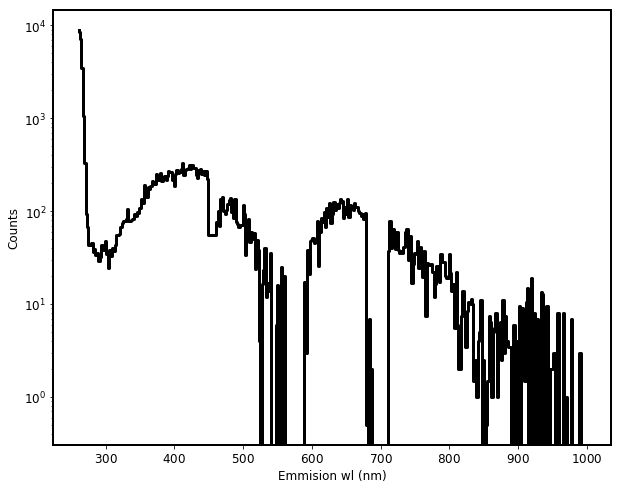

In [83]:
df.columns

plot1d(diff.em_wl, diff.counts, log=True)